# Capstone Project: Track 1 - e-commerce business / marketing setting
Gruppo: Luca Vanzetti, Michele Ragno, Benedetta Pollastrini, Daniele Coroneo
___

Al nostro gruppo di Business Intelligence è stato richiesto di **effettuare una analisi completa sull'andamento dell'attività del business di e-commerce**. 
Nello specifico ci è stato richiesto di concentrare lo studio sui seguenti ambiti: 
- Andamento delle vendite
- Scorte dei prodotti nei magazzini 
- Analisi performance dei prodotti
  
I dati aziendali sono archiviati nel seguente database BigQuery: `bigquery-public-data.thelook_ecommerce`. l'obbiettivo è interrogare ed estrarre il file dati, eseguire eventuali pulizie se necessario, manipolarli, analizzarli e creare una presentazione avvincente dei risultati ottenuti in Tableau, che successivamente andranno consegnati all'azienda.

### il diagramma E/R della sorgente dati


Una volta estrapolati i dati iniziali su BigQuery, andiamo a fare delle analisi esplorative sui dati estratti dalle tabelle SQL.

<figure>
<img src="data/img/Capstone Project - The Look e-commerce.jpeg" width="900">
</figure>


In [14]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

sns.set(rc={'figure.figsize':(15, 9)})
sns.color_palette("Paired")
sns.set(font_scale=1.5) 

______

## Analisi dei prodotti nei magazzini (Michele R.)
Le prime analisi che andremo ad effettuare con i dati estratti dai database sono 
 - Quali categorie e quanti prodotti sono disponibili nei vari magazzini.
 - Analizzare la distribuzione delle scorte nei magazzini presenti sul territorio.
 - Verificare eventuali "mancanze" o "stranezze" nelle scorte dei magazzini
____

### Categorie e Prodotti in stock
Utilizzando la query sottostante, estrapoliamo dalla mole di dati tutte le categorie di prodotti presenti nei magazzini e depositiamo il risultato della query in questo percorso `data/extracted data/product_items_instock.csv`: 

``` mysql
SELECT 
dist_center.id as distribution_center_id,
dist_center.name as distribution_center_name, 
inv_items.product_category,
inv_items.product_name,
inv_items.product_department,
count(inv_items.id) as nums_of_items_in_stock,
count(inv_items.sold_at) as nums_of_sold_items

FROM `bigquery-public-data.thelook_ecommerce.inventory_items` as inv_items
JOIN `bigquery-public-data.thelook_ecommerce.distribution_centers` as dist_center
ON inv_items.product_distribution_center_id = dist_center.id

GROUP BY 
dist_center.name, 
dist_center.id, 
inv_items.product_category,
inv_items.product_department

Order by product_category asc
```



Qui possiamo vedere che nei vari magazzini abbiamo una suddivisione di 26 categorie univoche per le scorte dei prodotti. E che la categoria `Intimates` è quella che presenta generalmente più scorte. Mentre le `Clothing Sets` sono presenti scorte in quantità limitata.

In [15]:
items_instock = pd.read_csv("data/extracted data/product_items_instock.csv")

categories = items_instock[["product_category"]].drop_duplicates(ignore_index=True)
categories

,product_category
0,Accessories
1,Active
2,Blazers & Jackets
3,Clothing Sets
4,Dresses
5,Fashion Hoodies & Sweatshirts
6,Intimates
7,Jeans
8,Jumpsuits & Rompers
9,Leggings


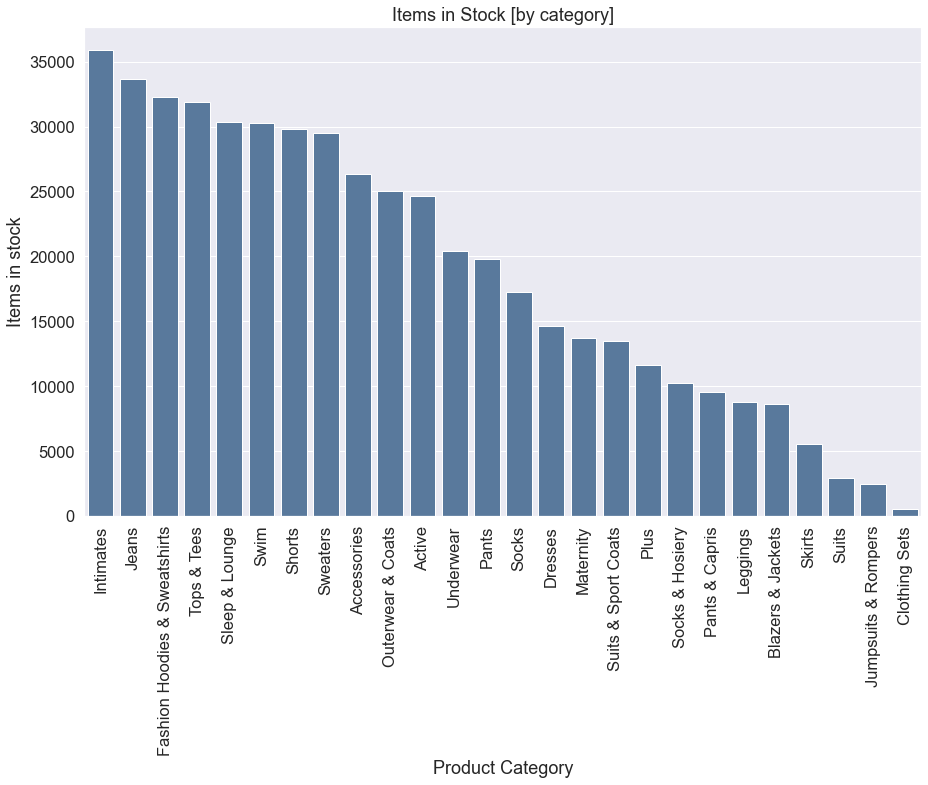

In [16]:
# Unisco le categorie con le scorte e sommo il totale delle scorte per categoria
count_item_cat_instock = categories.merge(items_instock, on="product_category")

count_item_cat_instock = count_item_cat_instock.groupby(["product_category"])['nums_of_items_in_stock'].sum().reset_index()
count_item_cat_instock.sort_values(by="nums_of_items_in_stock", ascending=False, inplace=True)

# Rappresentazione del grafico
sns.barplot(data=count_item_cat_instock, x="product_category", y="nums_of_items_in_stock", color="#4e79a7")
plt.xticks(rotation=90)
plt.xlabel('Product Category')
plt.ylabel('Items in stock')
plt.title('Items in Stock [by category]')
plt.show()

Inoltre, effettuando una ulteriore analisi sulla suddivisione dei prodotti, la maggior parte di questi sembra concentrata prettamente su prodotti femminili. Nonostante alcune delle categorie, presenti anche sul mercato, siano prodotti unisex.

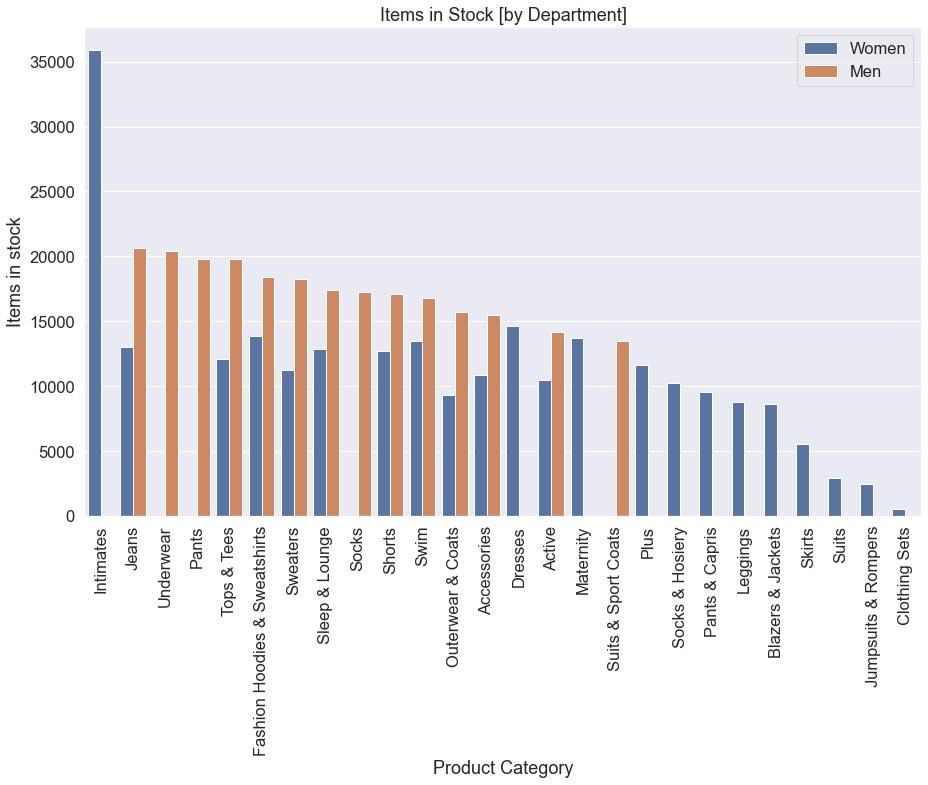

In [17]:
prod_cat_department = categories.merge(items_instock, on="product_category").sort_values(by="nums_of_items_in_stock", ascending=False)
prod_cat_department = prod_cat_department.groupby(["product_category", "product_department"])[["nums_of_items_in_stock"]].sum().reset_index()
prod_cat_depart_sorted = prod_cat_department.sort_values(by="nums_of_items_in_stock", ascending=False)

# Rappresentazione del grafico
sns.barplot(data=prod_cat_depart_sorted, x="product_category", y="nums_of_items_in_stock", hue="product_department")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.xlabel('Product Category')
plt.ylabel('Items in stock')
plt.title('Items in Stock [by Department]')
plt.show()

### Prodotti distribuiti nei magazzini
Analizziamo ora come i prodotti visualizzati precedentemente si distribuiscono tra i vari magazzini. 
Per prima cosa identifichiamo; quali sono i magazzini a nostra disposizione, visualizziamo la situazione generale delle scorte presenti e successivamente come le categorie di prodotti sono suddivisi in essi.

In [18]:
items_per_distr_center = items_instock.groupby(["distribution_center_name"])[["nums_of_items_in_stock"]].sum().reset_index()
print(items_per_distr_center["distribution_center_name"])
items_per_distr_center.sort_values(by="nums_of_items_in_stock", ascending=False, inplace=True)

0                                  Charleston SC
1                                     Chicago IL
2                                     Houston TX
3                                 Los Angeles CA
4                                     Memphis TN
5                                      Mobile AL
6                                 New Orleans LA
7                                Philadelphia PA
8    Port Authority of New York/New Jersey NY/NJ
9                                    Savannah GA
Name: distribution_center_name, dtype: object


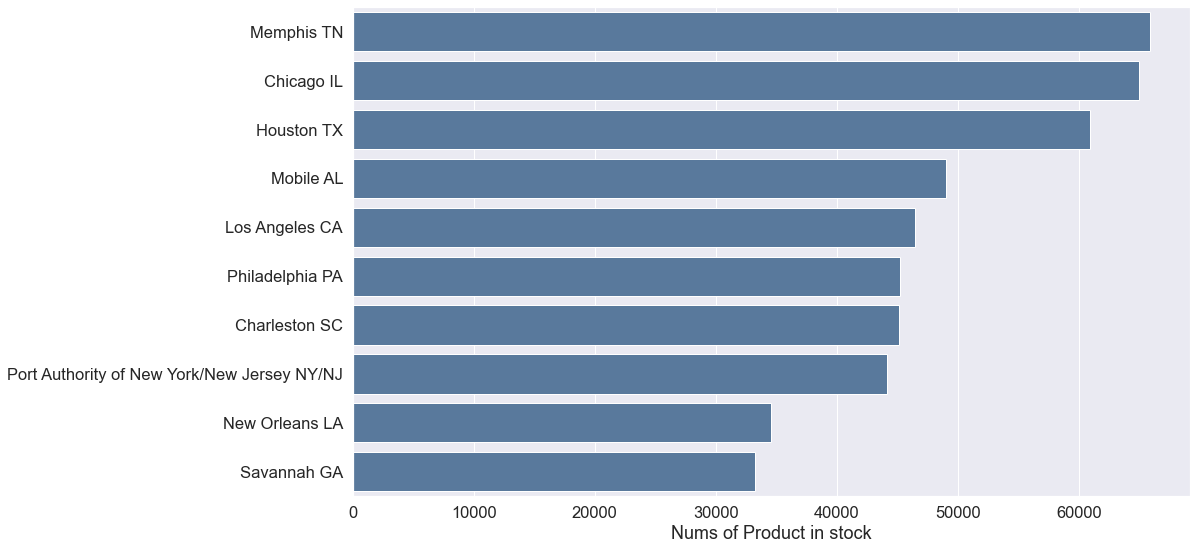

In [19]:
sns.barplot(data=items_per_distr_center, x="nums_of_items_in_stock", y="distribution_center_name", color="#4e79a7")
plt.ylabel(None)
plt.xlabel("Nums of Product in stock")
plt.show()

Di seguito, è riportato una heatmap dove sono riportate le numeriche delle scorte presenti nei magazzini, suddivisi in categorie di prodotti.
Notiamo subito che, le scorte non sono suddivise uniformemente e in alcuni casi ci sono magazzini che non possiedono nessuna scorta come:
 - Mobile AL e New Orleans LA: non possiedono scorte di **Suits & Sport Coats**
 - Philadelphia PA e Savannah GA: non possiedono scorte di **Clothing Sets**
 

In [20]:
prod_by_distr_center = items_instock.groupby(["distribution_center_name", "product_category"])[["nums_of_items_in_stock"]].sum().reset_index()
prod_by_distr_center = prod_by_distr_center.pivot("product_category", "distribution_center_name", "nums_of_items_in_stock")

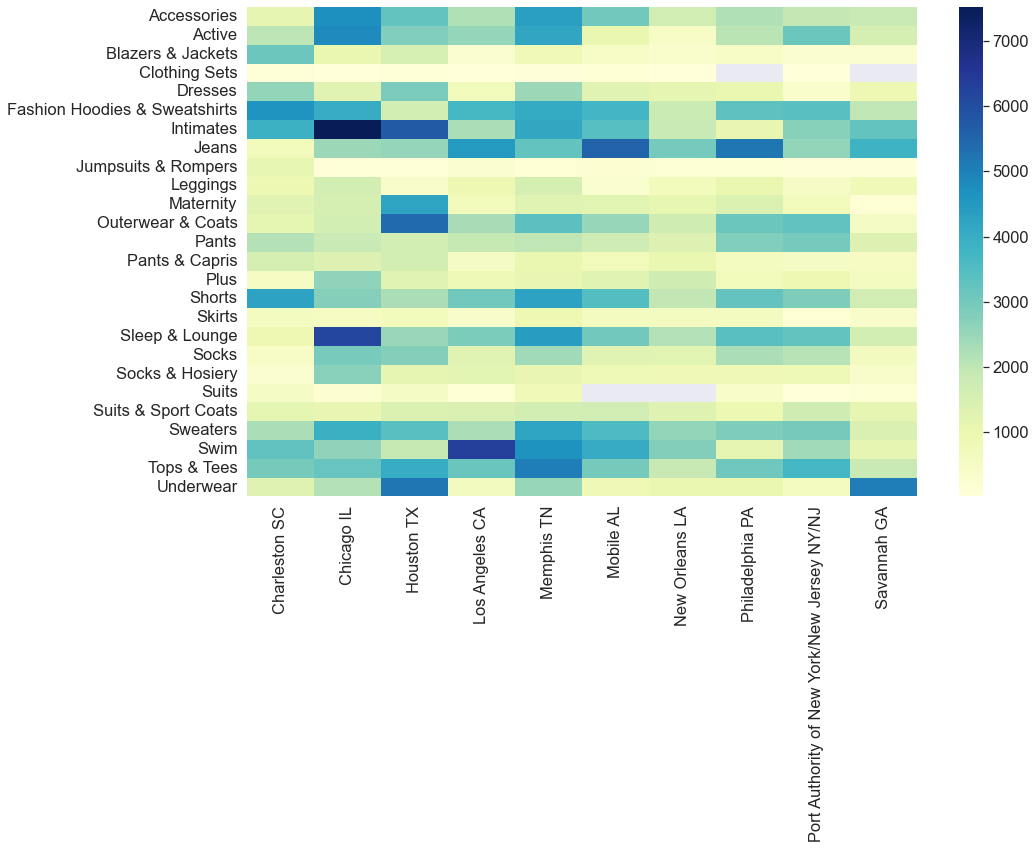

In [21]:
ax = sns.heatmap(prod_by_distr_center, cmap="YlGnBu")
plt.ylabel(None)
plt.xlabel(None)
plt.show()

### Analisi qualità consegne e valore degli utili
Ora che abbiamo analizzato la situazione delle merci in magazzino, ho voluto indagare ulteriormente sugli stati consegne (che effettuano i magazzini) e il valore degli utili presenti in ogni fase della consegna.
Tramite la query presente sotto, sono riuscito ad estrarre la differenza di ore impiegate nelle fasi di consegna dei magazzini e ho depositato l'estrazione qui: `data/extracted data/distr_center_performance.csv`: 

``` mysql
SELECT

dist_cent.name as distribution_center_name,
ord_items.status,
count(inv_items.id) as nums_of_items,
ROUND(AVG(DATE_DIFF(ord_items.shipped_at, ord_items.created_at, hour)),2) as hours_created_to_ship,
ROUND(AVG(DATE_DIFF(ord_items.delivered_at, ord_items.shipped_at, hour)),2) as hours_ship_to_deliver,

ROUND(SUM(ord_items.sale_price), 2) as sale_price_amount, 

MIN(ord_items.created_at) as oldest_created_ord_date,
MAX(ord_items.created_at) as newest_created_ord_date

FROM `bigquery-public-data.thelook_ecommerce.order_items` as ord_items 
JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` as inv_items
ON ord_items.inventory_item_id = inv_items.id
JOIN `bigquery-public-data.thelook_ecommerce.distribution_centers` as dist_cent
ON inv_items.product_distribution_center_id = dist_cent.id

GROUP BY 
dist_cent.name,
ord_items.status

```

E' emerso che:
 - **Houston TX, Memphis TN e Chicago IL** sono i magazzini dove si concentra la maggioranza del valore degli utili.
 - 


In [22]:
distr_center_data = pd.read_csv("data/extracted data/distr_center_performance.csv")
distr_center_data.sort_values(by="distribution_center_name", ascending=True)
distr_center_data.head()

,distribution_center_name,status,nums_of_items,hours_created_to_ship,hours_ship_to_deliver,sale_price_amount,oldest_created_ord_date,newest_created_ord_date
0,Houston TX,Shipped,6919,12.68,NaN,487476.59,2019-01-14T13:10:39Z,2022-09-29T23:26:20.131Z
1,Houston TX,Cancelled,3433,NaN,NaN,235603.02,2019-02-17T11:46:51Z,2022-09-30T14:56:43.269Z
2,Houston TX,Returned,2228,11.90,58.31,152020.98,2019-02-05T08:20:24Z,2022-09-30T11:48:01Z
3,Houston TX,Complete,5728,12.52,59.58,398158.01,2019-01-12T05:15:51Z,2022-09-30T00:19:48.334Z
4,Houston TX,Processing,4537,NaN,NaN,316900.65,2019-01-23T05:46:39Z,2022-09-30T17:47:24Z


In [23]:
distr_center_data['oldest_created_ord_date'] = pd.to_datetime(distr_center_data['oldest_created_ord_date'])
distr_center_data['oldest_created_ord_date'] = distr_center_data['oldest_created_ord_date'].dt.strftime('%d/%m/%Y - %H:%M')

# Semplifico il nome
cond = distr_center_data['distribution_center_name'] == "Port Authority of New York/New Jersey NY/NJ"
distr_center_data['distribution_center_name'].loc[cond] = "New York/New Jersey NY/NJ"

# Formatto la data
distr_center_data['newest_created_ord_date'] = pd.to_datetime(distr_center_data['newest_created_ord_date'])
distr_center_data['newest_created_ord_date'] = distr_center_data['newest_created_ord_date'].dt.strftime('%d/%m/%Y - %H:%M')
distr_center_data.head()

C:\Users\michele.ragno\AppData\Local\Temp\ipykernel_4552\4010994608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distr_center_data['distribution_center_name'].loc[cond] = "New York/New Jersey NY/NJ"


,distribution_center_name,status,nums_of_items,hours_created_to_ship,hours_ship_to_deliver,sale_price_amount,oldest_created_ord_date,newest_created_ord_date
0,Houston TX,Shipped,6919,12.68,NaN,487476.59,14/01/2019 - 13:10,29/09/2022 - 23:26
1,Houston TX,Cancelled,3433,NaN,NaN,235603.02,17/02/2019 - 11:46,30/09/2022 - 14:56
2,Houston TX,Returned,2228,11.90,58.31,152020.98,05/02/2019 - 08:20,30/09/2022 - 11:48
3,Houston TX,Complete,5728,12.52,59.58,398158.01,12/01/2019 - 05:15,30/09/2022 - 00:19
4,Houston TX,Processing,4537,NaN,NaN,316900.65,23/01/2019 - 05:46,30/09/2022 - 17:47


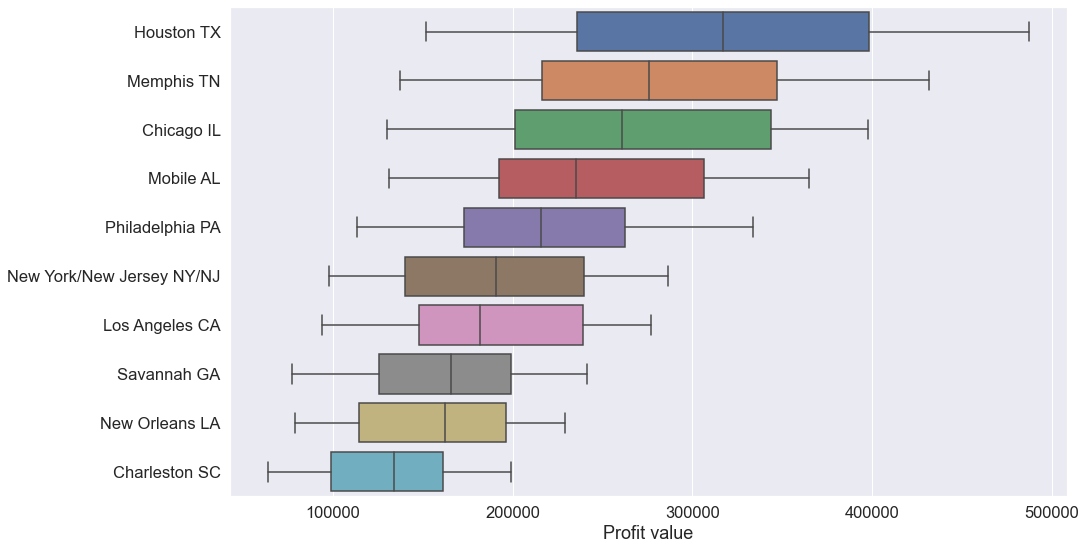

In [24]:
distr_center_data.sort_values(by="sale_price_amount", ascending=False, inplace=True)
sns.boxplot(data=distr_center_data, x="sale_price_amount", y="distribution_center_name")
plt.ylabel(None)
plt.xlabel("Profit value")
plt.show()

In [25]:
processing_performance = distr_center_data[(distr_center_data["status"] == "Processing") | (distr_center_data["status"] == "Complete")]
processing_performance.sort_values(by="distribution_center_name", ascending=True)

,distribution_center_name,status,nums_of_items,hours_created_to_ship,hours_ship_to_deliver,sale_price_amount,oldest_created_ord_date,newest_created_ord_date
28,Charleston SC,Processing,3357,NaN,NaN,133885.95,12/01/2019 - 06:49,29/09/2022 - 17:31
25,Charleston SC,Complete,4097,12.34,59.35,161231.09,15/02/2019 - 06:05,30/09/2022 - 05:03
39,Chicago IL,Complete,6142,13.62,59.35,343890.92,15/01/2019 - 03:21,30/09/2022 - 10:58
36,Chicago IL,Processing,4641,NaN,NaN,261129.10,09/02/2019 - 10:01,30/09/2022 - 15:58
3,Houston TX,Complete,5728,12.52,59.58,398158.01,12/01/2019 - 05:15,30/09/2022 - 00:19
4,Houston TX,Processing,4537,NaN,NaN,316900.65,23/01/2019 - 05:46,30/09/2022 - 17:47
19,Los Angeles CA,Processing,3436,NaN,NaN,181844.19,23/02/2019 - 13:17,30/09/2022 - 00:11
15,Los Angeles CA,Complete,4327,13.05,59.65,239129.09,19/01/2019 - 15:20,30/09/2022 - 12:16
31,Memphis TN,Processing,4889,NaN,NaN,275782.87,21/01/2019 - 11:22,30/09/2022 - 14:59
35,Memphis TN,Complete,5944,13.47,58.96,347020.47,12/01/2019 - 06:32,30/09/2022 - 15:42


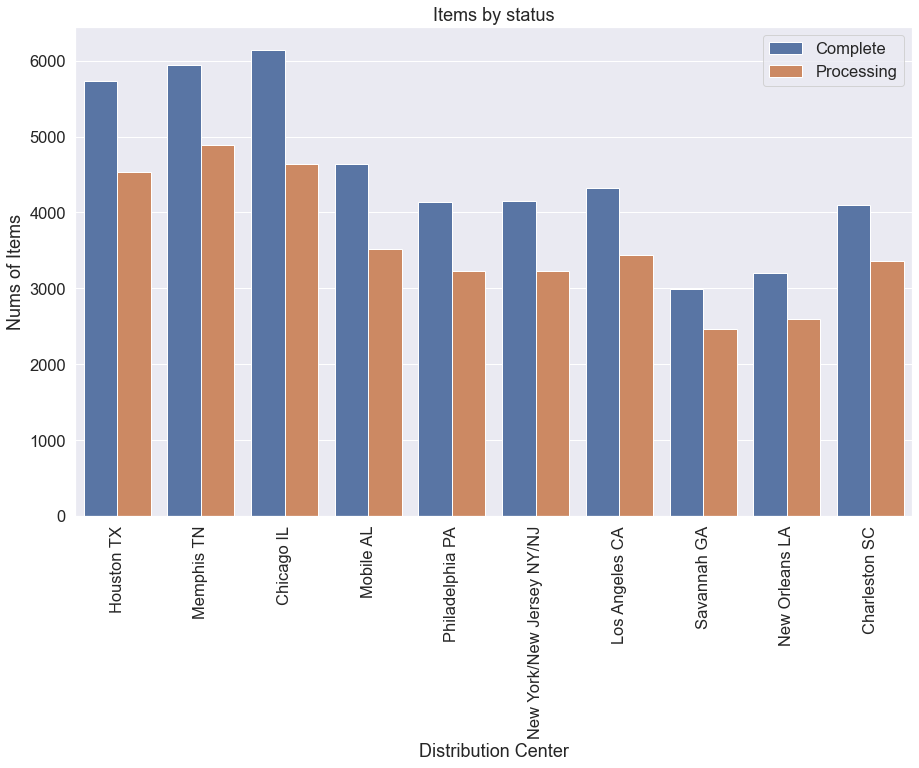

In [26]:
# Rappresentazione del grafico
sns.barplot(data=processing_performance, x="distribution_center_name", y="nums_of_items", hue="status")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.xlabel('Distribution Center')
plt.ylabel('Nums of Items')
plt.title('Items by status')
plt.show()